https://github.com/mohamedelhakim/Transformer-CNN-Architecture

# Import modules

The hybrid model combines a Convolutional Neural Network (CNN) and a Transformer to classify ECG signals. The CNN first extracts local features from the input signal, capturing patterns like peaks and troughs. The output of the CNN is then passed to a Transformer, which processes these features to capture long-range dependencies, learning relationships between distant points in the signal. This approach leverages the strengths of both architectures: the CNN’s ability to focus on local patterns and the Transformer’s capacity to understand global context. The final output is a classification of the ECG signal, benefiting from both local and global feature learning.

In [1]:
import pandas as pd
import numpy as np
import os
import copy
import math

import torch
from torch import nn, optim
import torch.nn.functional as F

import pytorch_lightning as pl
from torchmetrics.classification import Accuracy
from torch.optim import Adam



from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, TensorDataset

In [2]:
import matplotlib.pyplot as plt

In [3]:
# X=rnnamp_model['text']
# y=np.array(rnnamp_model['labels'])




In [4]:
# rnnamp_model = pd.read_csv('/kaggle/input/hemolytic/combined.csv')

dataframes = {}
directory_path = 'Heartbeat_Dataset'
all_files = os.listdir(directory_path)

for file in os.listdir(directory_path):
    if file.endswith('.csv'):
        file_path = os.path.join(directory_path, file)
        # Remove the .csv extension for the DataFrame name
        df_name = os.path.splitext(file)[0]
        dataframes[df_name] = pd.read_csv(file_path, header= None)



In [5]:
train_df = dataframes['mitbih_train']

In [6]:
labels = {
    0.0: "N",
    1.0: "S",
    2.0: "V",
    3.0: "F",
    4.0: "Q"
}

train_df.iloc[:, -1] = train_df.iloc[:, -1].replace(labels)

# Now get the value counts for the renamed last column
train_counts = train_df.iloc[:, -1].value_counts()

# Print the counts
print(train_counts)

187
N    72471
Q     6431
V     5788
S     2223
F      641
Name: count, dtype: int64


C:\Users\randa\AppData\Local\Temp\ipykernel_72984\4019137323.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0        N
1        N
2        N
3        N
4        N
        ..
87549    Q
87550    Q
87551    Q
87552    Q
87553    Q
Name: 187, Length: 87554, dtype: object' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  train_df.iloc[:, -1] = train_df.iloc[:, -1].replace(labels)


In [7]:
train_df

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,N
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,N
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,N
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,N
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87549,0.807018,0.494737,0.536842,0.529825,0.491228,0.484211,0.456140,0.396491,0.284211,0.136842,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Q
87550,0.718333,0.605000,0.486667,0.361667,0.231667,0.120000,0.051667,0.001667,0.000000,0.013333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Q
87551,0.906122,0.624490,0.595918,0.575510,0.530612,0.481633,0.444898,0.387755,0.322449,0.191837,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Q
87552,0.858228,0.645570,0.845570,0.248101,0.167089,0.131646,0.121519,0.121519,0.118987,0.103797,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Q


In [8]:
x_data = train_df.iloc[:,:187]
y_label = train_df.iloc[:,-1]

In [9]:
y_label.value_counts()

187
N    72471
Q     6431
V     5788
S     2223
F      641
Name: count, dtype: int64

In [10]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_label)  # Encode labels without replacement
num_classes = len(label_encoder.classes_)  # Use the number of unique classes
y = np.eye(num_classes)[y] 

In [11]:
X_train, X_test, y_train, y_test = train_test_split(x_data, y, test_size=0.2, random_state=42)

In [12]:
X_train = np.expand_dims(X_train, axis=1)  # Change axis from 2 to 1
X_test = np.expand_dims(X_test, axis=1)    # Change axis from 2 to 1

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train).float()  # Ensure the data is of float type
X_test_tensor = torch.tensor(X_test).float()    # Ensure the data is of float type
y_train_tensor = torch.tensor(y_train).long()   # Ensure labels are long type
y_test_tensor = torch.tensor(y_test).long()   

y_train_tensor = y_train_tensor.argmax(dim=1)  # Reduces [70043, 5] to [70043]
y_test_tensor = y_test_tensor.argmax(dim=1)
# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [13]:
print("X_train_tensor shape:", X_train_tensor.shape)  #
print("y_train_tensor shape:", y_train_tensor.shape) 

X_train_tensor shape: torch.Size([70043, 1, 187])
y_train_tensor shape: torch.Size([70043])


In [14]:
print(train_dataset)
print(train_loader)

In [15]:
class CNNTransformerHybrid(nn.Module):
    def __init__(self, input_dim, num_classes, num_heads, num_layers, d_model=128):
        super(CNNTransformerHybrid, self).__init__()

        # CNN Feature extractor with Conv1d
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        
        # MaxPooling layer
        self.pool = nn.MaxPool1d(kernel_size=2)

        # Batch normalization after convolutions
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(256)

        # Projection layer to match transformer input size
        self.projector = nn.Linear(256, d_model)

        # Transformer encoder
        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=d_model, nhead=num_heads), num_layers=num_layers
        )

        # Fully connected layer to output the final classification
        self.fc = nn.Linear(d_model, num_classes)

        # Dropout layer for regularization
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Ensure input is of shape (batch_size, channels, seq_len)
        if x.ndimension() == 2:
            x = x.unsqueeze(1)  # Add channel dimension
        
        # Convolutional layers with ReLU, batch normalization, and pooling
        x = self.pool(F.relu(self.bn1(self.conv1(x)))) 
        x = self.pool(F.relu(self.bn2(self.conv2(x)))) 
        x = self.pool(F.relu(self.bn3(self.conv3(x)))) 
        
        # Flattening and projection for transformer input
        x = x.permute(0, 2, 1)  # (batch_size, seq_len, channels)
        x = self.projector(x)  # Project to transformer input size

        # Transformer encoding
        x = x.permute(1, 0, 2)  # Change to (seq_len, batch_size, d_model)
        x = self.encoder(x)  # Apply transformer layers

        # Pool the transformer output (use the last token for classification or apply mean)
        x = x.mean(dim=0)  # Aggregate over sequence length (or use last token: x[-1])
        x = self.fc(self.dropout(x))  # Fully connected layer after dropout

        return x


# Model instantiation
model = CNNTransformerHybrid(
    input_dim=187,  # Number of features per sample (input dimension)
    num_classes=5,  # Number of output classes
    num_heads=8,    # Multi-head attention heads
    num_layers=6,   # Number of Transformer layers
    d_model=128     # Dimension of transformer model
)




c:\Users\randa\OneDrive\Documents\GitHub\Neural-Networks-Project\.venv\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [16]:
# Print model summary
print(model)

CNNTransformerHybrid(
  (conv1): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv3): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (projector): Linear(in_features=256, out_features=128, bias=True)
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=2048, bias=True)
        (dropout

In [17]:
# Define a simple training and testing loop
def train(model, train_loader, optimizer, criterion, device):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0
    
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


def test(model, test_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():  # No need to compute gradients during testing
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            
            # Forward pass
            output = model(data)
            
            # Calculate the loss
            loss = criterion(output, target)
            running_loss += loss.item()
            
            # Get the predicted class
            _, predicted = torch.max(output, 1)
            
            total += target.size(0)
            correct += (predicted == target).sum().item()
            
            # Save predictions and labels for additional evaluation if needed
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(target.cpu().numpy())
    
    epoch_loss = running_loss / len(test_loader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc, all_preds, all_labels


# Set the device (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model
model = CNNTransformerHybrid(
    input_dim=187,  # Number of features per sample (input dimension)
    num_classes=5,  # Number of output classes
    num_heads=8,  # Multi-head attention heads
    num_layers=6  # Number of Transformer layers
).to(device)

# Define the loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()  # Suitable for multi-class classification
optimizer = optim.Adam(model.parameters(), lr=1e-4)  # Optimizer with a learning rate of 1e-4

# Number of epochs to train
epochs = 25
train_accuracies  = []  
test_accuracies  = []

for epoch in range(epochs):
    # Train the model
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
    train_accuracies.append(train_acc) 
    print(f"Epoch {epoch+1}/{epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
    
    # Test the model
    test_loss, test_acc, preds, labels = test(model, test_loader, criterion, device)
    test_accuracies.append(test_acc)
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

# Optionally: Save the trained model
# torch.save(model.state_dict(), "cnn_transformer_model.pth")


Epoch 1/25
Train Loss: 0.2258, Train Accuracy: 0.9414
Test Loss: 0.1439, Test Accuracy: 0.9627
Epoch 2/25
Train Loss: 0.1405, Train Accuracy: 0.9639
Test Loss: 0.1013, Test Accuracy: 0.9729
Epoch 3/25
Train Loss: 0.1181, Train Accuracy: 0.9698
Test Loss: 0.0879, Test Accuracy: 0.9747
Epoch 4/25
Train Loss: 0.1046, Train Accuracy: 0.9735
Test Loss: 0.0915, Test Accuracy: 0.9726
Epoch 5/25
Train Loss: 0.0935, Train Accuracy: 0.9759
Test Loss: 0.0901, Test Accuracy: 0.9757
Epoch 6/25
Train Loss: 0.0841, Train Accuracy: 0.9773
Test Loss: 0.0787, Test Accuracy: 0.9795
Epoch 7/25
Train Loss: 0.0782, Train Accuracy: 0.9792
Test Loss: 0.0708, Test Accuracy: 0.9785
Epoch 8/25
Train Loss: 0.0731, Train Accuracy: 0.9810
Test Loss: 0.0698, Test Accuracy: 0.9790
Epoch 9/25
Train Loss: 0.0675, Train Accuracy: 0.9819
Test Loss: 0.0688, Test Accuracy: 0.9809
Epoch 10/25
Train Loss: 0.0641, Train Accuracy: 0.9827
Test Loss: 0.0614, Test Accuracy: 0.9838
Epoch 11/25
Train Loss: 0.0587, Train Accuracy: 0

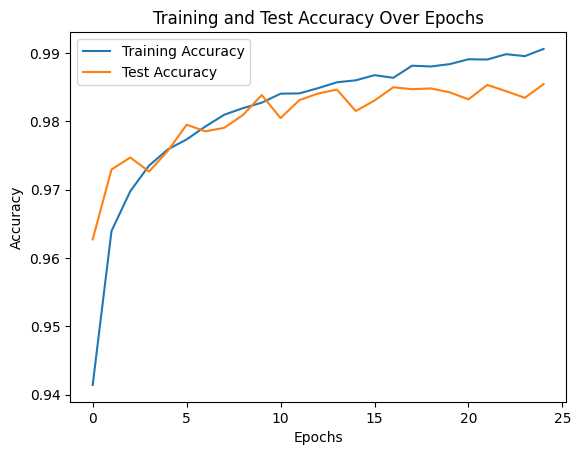

In [22]:
num_epochs = min(len(train_accuracies), len(test_accuracies))

plt.figure()
plt.plot(np.arange(num_epochs), train_accuracies[:num_epochs], label='Training Accuracy')
plt.plot(np.arange(num_epochs), test_accuracies[:num_epochs], label='Test Accuracy')

# Add labels and legend
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy Over Epochs')
plt.legend()
plt.show()

In [23]:
model_path = "./model/cnn_transformer_model2.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

Model saved to ./model/cnn_transformer_model2.pth


# Testing the model

In [24]:
test_df = dataframes['mitbih_test']
print(test_df.shape)

(21892, 188)


In [25]:
labels = {
    0.0: "N",
    1.0: "S",
    2.0: "V",
    3.0: "F",
    4.0: "Q"
}

train_df.iloc[:, -1] = train_df.iloc[:, -1].replace(labels)

x_data = train_df.iloc[:,:187]
y_label = train_df.iloc[:,-1]

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_label.values.ravel())


# Prepare data for model
X = x_data
X_test = np.expand_dims(X, axis=1)    # Add a new dimension to match model input
X_test_tensor = torch.tensor(X_test).float()    # Convert to float tensor
y_test_tensor = torch.tensor(y).long()          # Convert to long tensor for labels

# Create DataLoader
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [26]:
model.eval()
correct_predictions = 0
total_predictions = 0

# Evaluate the model
def test(model, test_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():  # No need to compute gradients during testing
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            
            # Forward pass
            output = model(data)
            
            # Calculate the loss
            loss = criterion(output, target)
            running_loss += loss.item()
            
            # Get the predicted class
            _, predicted = torch.max(output, 1)
            
            total += target.size(0)
            correct += (predicted == target).sum().item()
            
            # Save predictions and labels for additional evaluation if needed
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(target.cpu().numpy())
    
    epoch_loss = running_loss / len(test_loader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc, all_preds, all_labels


In [27]:
criterion = torch.nn.CrossEntropyLoss()  # For multi-class classification

epoch_loss, epoch_acc, all_preds, all_labels = test(model, test_loader, criterion, device)
print(f"Test Loss: {epoch_loss:.4f}, Test Accuracy: {epoch_acc:.4f}")

Test Loss: 0.0269, Test Accuracy: 0.9924
